In [1]:
'''
Title:              MasterScript_Working.ipynb

Description:        This script gives a projection for the yearly energy output produced
                    by a solar site in MWh. It first establishes several variables which
                    will change from site to site; then it calls the optimize_axistilt 
                    function, which takes the average height of all panels and finds the
                    axis tilt which will produce the highest energy generation. Finally,
                    it seperates the modules into different buckets, based on reveal height
                    and whether its internal or external. It comes up with a projection for
                    that bucket, then multiplies by the number of modules in that bucket.
                
                
Dependencies:       pvtune.py:          processes pvtune output; determines the number of modules
                                        in each row. creates buckets for each reveal height
                                        
                    monthly_albedo.py:  takes excel sheets from weather database and calculates
                                        average albedo for each month. uses that rather than a 
                                        nonvariable scalar 
                                        
                    monthly_snow.py:    script for adjusting the row height to account for any
                                        snowfall
                    
                    basic_predictor.py: the function that each bucket is put through: takes the
                                        site characteristics and comes up with a yearly energy
                                        generation for that single module.
                    
                    optimizer.py:       optimizes the axis tilt parameter, trying to maximize 
                                        the yearly energy output.
                
Date Created:       8/14/2024
Last Updated:       8/15/2024

Author:             Jacob Price 
Company:            Kimley-Horn

'''

# Imports
import warnings

from pvlib import pvsystem
from pvlib.temperature import TEMPERATURE_MODEL_PARAMETERS as PARAMS

from optimizer import optimize_axistilt
from basic_predictor import calculate_total_energy

# Suppress specific warnings
warnings.filterwarnings('ignore', category=FutureWarning, module='pandas')
warnings.filterwarnings('ignore', category=RuntimeWarning, module='pvlib')
warnings.filterwarnings(action='ignore', module='pvfactors')
warnings.filterwarnings(action='ignore', module='optuna')

c:\Users\jacob.price\Documents\Python\attempt2\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


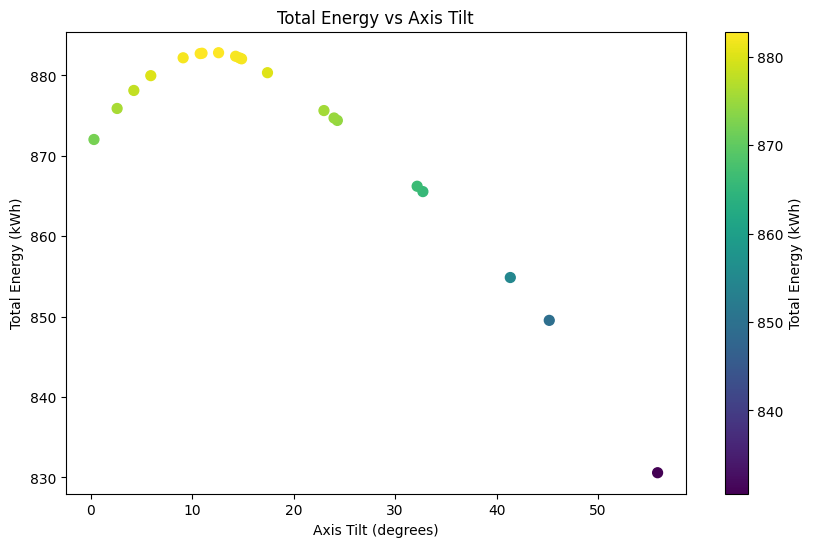

Optimal Axis Tilt: 12.58740145349472
Maximized Total Energy: 882.83 kWh
    Max Reveal Height Description  Number_of_Rows  Number_of_Total_Modules  \
0                5.00         Ext             246                    23608   
1                5.00         Int            1375                   137462   
2                5.25         Ext             147                    14326   
3                5.25         Int            1107                   111930   
4                5.50         Ext              87                     8658   
5                5.50         Int             640                    64402   
6                5.75         Ext              29                     2938   
7                5.75         Int             325                    32344   
8                6.00         Ext              36                     3484   
9                6.00         Int             185                    18382   
10               6.25         Ext              12                     

In [2]:
# File paths for necessary data
pvtune_filepath = "pvtune_output.csv"  # File path for the pvtune output
albedodata_filepath = "Albedo_TimeSeries/Limewood-data"  # File path for albedo time series data

# Site location and time characteristics
lat = 31.138828  # Latitude of the site
lon = -97.262552  # Longitude of the site
tz = 'Etc/GMT+5'  # Time zone of the site

# Site system characteristics
gcr = 0.4  # Ground coverage ratio of the site
max_angle = 60  # Maximum tilt angle for solar panels
pvrow_width = 5  # Width of the PV row in meters
bifaciality = 0.8  # Bifaciality factor for the solar panels

# Inverter and module parameters
temp_model_parameters = PARAMS['sapm']['open_rack_glass_glass']  # Temperature model parameters
cec_modules = pvsystem.retrieve_sam('CECMod')  # Retrieve the CEC modules data
cec_module = cec_modules['Trina_Solar_TSM_360DEG14C_07_II_']  # Specify the solar module to be used
cec_inverters = pvsystem.retrieve_sam('cecinverter')  # Retrieve the CEC inverters data
cec_inverter = cec_inverters['ABB__MICRO_0_25_I_OUTD_US_240__240V_']  # Specify the inverter to be used

# Site name
site_name = 'Limewood, TX'  # Name of the site

# Call the optimization function to find the optimal axis tilt and maximize total energy output
optimal_axistilt, maximized_total_energy, summary_df = optimize_axistilt(
    pvtune_filepath, albedodata_filepath, lat, lon, tz, gcr, max_angle, pvrow_width, bifaciality, 
    temp_model_parameters, cec_modules, cec_module, cec_inverters, cec_inverter, site_name
)

# Print the results of the optimization
print(f"Optimal Axis Tilt: {optimal_axistilt}")  # Print the optimal axis tilt found
print(f"Maximized Total Energy: {maximized_total_energy:.2f} kWh")  # Print the maximized total energy in kWh
print(summary_df)  # Print the summary DataFrame with detailed output


In [5]:
# Initialize the total energy projection for the entire site
tot_projection = 0

# Iterate through each row in the DataFrame
for i in range(len(summary_df)):
    # Initialize the energy bucket for each row (subsection of the site)
    bucket_energy = 0
    
    # Extract parameters from the current row
    height = summary_df.iloc[i, 0]  # Extract PV row height
    ext_or_int = summary_df.iloc[i, 1]  # Extract whether the row is external or internal
    num_modules = summary_df.iloc[i, 3]  # Extract the number of modules in this row
    
    # Calculate the total energy for the current configuration
    output = calculate_total_energy(height, ext_or_int, optimal_axistilt, albedodata_filepath,
                                    lat, lon, tz, gcr, max_angle, pvrow_width, bifaciality, 
                                    temp_model_parameters, cec_modules, cec_module, cec_inverters, 
                                    cec_inverter, site_name)
    
    # Calculate the energy for this specific row based on the number of modules
    bucket_energy += (output * num_modules)
    
    # Add the row's energy contribution to the total site projection
    tot_projection += bucket_energy



Total Yearly Projection for Entire Site: 379729.34 MWh
Annual Generated Cost (at $30.00/MWh): $11391880.34


In [6]:
# Print the total yearly energy projection for the entire site in MWh
print(f"Total Yearly Projection for Entire Site: {round(tot_projection / 1000, 2):.2f} MWh")

print(f"Annual Generated Cost (at $25.00/MWh): ${round(25*tot_projection / 1000, 2):.2f}")

Total Yearly Projection for Entire Site: 379729.34 MWh
Annual Generated Cost (at $25.00/MWh): $9493233.62
